In [3]:
# 욜로로 이미지 감지 후 이미지에 대한 설명(TEXT)
!pip install -U langchain langchain-core langchain-community langchain-google-genai google-genai langchain-openai python-dotenv
!pip install -U sentence-transformers
!pip install -U chromadb
!pip install ultralytics

  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_google_genai-3.2.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain_openai-1.1.0-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: google-ai-generativelanguage
    Found exi

  Using cached ultralytics-8.3.233-py3-none-any.whl.metadata (37 kB)
Using cached ultralytics-8.3.233-py3-none-any.whl (1.1 MB)


In [9]:
import cv2
from ultralytics import YOLO
import os

model = YOLO("yolov8n.pt")

image_path = "persons.jpeg"
image = cv2.imread(image_path)
if image is None:
  print("이미지 로딩 실패")
  raise FileNotFoundError(f"이미지 없음 : {image_path}")

results = model(image)
# print(results)
os.makedirs("cropped", exist_ok=True) # Changed makedir to makedirs

person_count = 0 # Initialize person_count
for result in results:
  for i, box in enumerate(result.boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # 바운딩 좌표
    label = result.names[int(box.cls[0])]   # 클래스
    confidence = box.conf[0].item()

    if label.lower()=="person":
      person_count += 1
      cropped = image[y1:y2, x1:x2]
      crop_filename = f"cropped/person{person_count}.jpg"     # 파일명 설정
      cv2.imwrite(crop_filename, cropped)
      print(f"{crop_filename}저장됨")
print(f"총 감지된 사람 수 : {person_count}명")


0: 448x640 4 persons, 1 handbag, 161.2ms
Speed: 4.8ms preprocess, 161.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
cropped/person1.jpg저장됨
cropped/person2.jpg저장됨
cropped/person3.jpg저장됨
cropped/person4.jpg저장됨
총 감지된 사람 수 : 4명


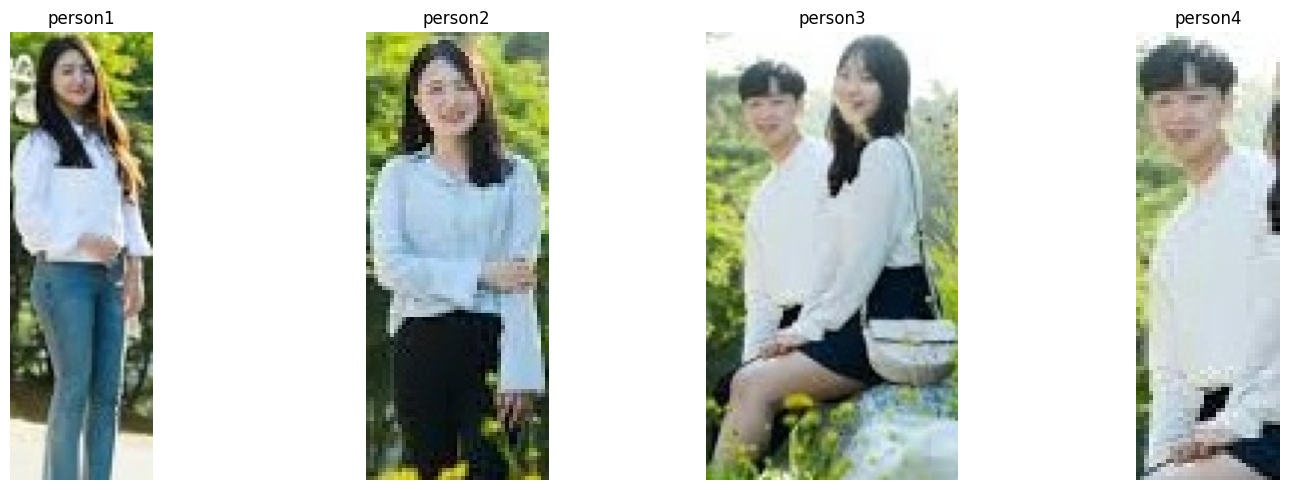

In [13]:
# 저장된 이미지 출력
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if person_count == 0:
  print("표시할 사람 없음")
else:
  fig, axes = plt.subplots(1, person_count, figsize=(4*person_count, 5))

  if person_count == 1:
    axes = [axes]

  for i in range(1, person_count+1):
    img_path =  f"cropped/person{i}.jpg"
    img = mpimg.imread(img_path)
    axes[i - 1].imshow(img)
    axes[i - 1].set_title(f"person{i}")
    axes[i - 1].axis('off') # 눈금자가 사라짐

plt.tight_layout()
plt.show()
+

In [16]:
from langchain_core.messages import HumanMessage
# 랭체인 멀티모달
import base64
from langchain_google_genai import ChatGoogleGenerativeAI
from PIL import Image
import os
from dotenv import load_dotenv
from google.colab import userdata # Colab 환경에서 보안 정보를 가져오기 위해 userdata 모듈 임포트

# from typing import List, Dict, Any
# from pathlib import Path
# from langchain_core.output_parsers import StrOutputParser

load_dotenv() # .env 파일에서 환경 변수를 로드 (Colab 환경에서는 userdata가 더 자주 사용됨)


# Gemini 모델 초기화 및 설정
llm = ChatGoogleGenerativeAI(
    temperature=0.2,  # 모델의 창의성(무작위성)을 0.2로 설정 (낮은 값은 더 결정론적이고 일관된 응답을 유도)
    model="gemini-2.5-flash", # 이미지 분석에 최적화된 빠른 멀티모달 모델 사용
    google_api_key=userdata.get('GOOGLE_API_KEY') # Colab의 보안 저장소에서 API 키를 가져와 설정
)

prompt_text = "현재 이미지를 보고 무슨 내용인지 설명 해봐"

for i in range(1, person_count +1):
  image_path = f"cropped/person{i}.jpg"
  with open(image_path, "rb") as f:
    encoded_image = base64.b64encode(f.read()).decode("utf-8")
  print(encoded_image)

  # 멀티모달 메세지 구성
  message = HumanMessage(
      content = [
          {"type": "text","text":prompt_text},
          {
              "type":"image_url",
              "image_url":{
                  "url":f"data:image/jpeg;base64, {encoded_image}"
              },
          },

      ]
  )
  response = llm.invoke([message])
  print("설명 내용 : ")
  print(response.content.strip())


/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCACaADEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDlb341eMvGLWGjHxtJb+GIQILm8s7KSMwwsoQB5AhGDGMYZ85BzxgnxX9sT9rXVv2Wtatfhx8FPiFe3Gp3kEd3NfSQIEt4lbMflkykZJBJLYGFJ9q/ZHxf8IfEHwn0nX/h34e+GsWh/CzV/wC07jxfpmn+GI5bfVH1aby4o/3L